<a href="https://colab.research.google.com/github/Slim205/Nuclear-Reactor-Safety-Study/blob/main/Conformal_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Train

In [ ]:

datatrain = pd.read_csv('train.csv')
Xtrain = datatrain[['Enthalpie_R1', 'Pression_R1', 'Carac_evac_R1', 'Temperature_R2', 'Puissance_P1_R2', 'Puissance_P2_R2']].values
Ytrain = datatrain['Critere_temperature'].values
datatest = pd.read_csv('test.csv')
Xtest = datatest[['Enthalpie_R1', 'Pression_R1', 'Carac_evac_R1', 'Temperature_R2', 'Puissance_P1_R2', 'Puissance_P2_R2']].values
Ytest = datatest['Critere_temperature'].values
ytrain = datatrain['Critere_temperature'].apply(lambda x: 1 if x > 0 else 0).values
ytest = datatest['Critere_temperature'].apply(lambda x: 1 if x > 0 else 0).values
scaler = StandardScaler()
Xtrain = scaler.fit_transform(Xtrain)
Xtest = scaler.fit_transform(Xtest)

# Définition du modèle :
model = tf.keras.Sequential([
    tf.keras.layers.Dense(6),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(1)
  ])


model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(Xtrain, Ytrain, epochs=300)


neurone_pred = model.predict(Xtest)[:,0]
# classification douce
for i in range(500) :
  if neurone_pred[i] > 0:
    neurone_pred[i] =1
  else :
    neurone_pred[i] = 0

# Test du modèle
l2 = abs(neurone_pred - ytest)
print((1- l2.sum()/500)*100)



Epoch 1/300
10/10 [==============================] - 5s 15ms/step - loss: 488.6869
Epoch 2/300
10/10 [==============================] - 0s 9ms/step - loss: 486.2079
Epoch 3/300
10/10 [==============================] - 0s 10ms/step - loss: 483.5411
Epoch 4/300
10/10 [==============================] - 0s 10ms/step - loss: 480.9983
Epoch 5/300
10/10 [==============================] - 0s 9ms/step - loss: 478.2603
Epoch 6/300
10/10 [==============================] - 0s 6ms/step - loss: 475.2480
Epoch 7/300
10/10 [==============================] - 0s 7ms/step - loss: 471.7469
Epoch 8/300
10/10 [==============================] - 0s 8ms/step - loss: 467.7721
Epoch 9/300
10/10 [==============================] - 0s 4ms/step - loss: 462.6412
Epoch 10/300
10/10 [==============================] - 0s 5ms/step - loss: 456.8361
Epoch 11/300
10/10 [==============================] - 0s 8ms/step - loss: 450.1122
Epoch 12/300
10/10 [==============================] - 0s 6ms/step - loss: 442.6845
Epoch 13/3

In [ ]:
Xtrain.head()

AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [ ]:
mean_values = scaler.mean_
std = scaler.scale_
print(mean_values)
print(std)

[7.13225680e+04 4.26555755e+01 1.33972455e+03 3.35604402e+01
 5.04527900e-01 5.02689420e-01]
[2.19365560e+04 7.27394239e-01 3.18051803e+02 1.53038647e+01
 2.88096633e-01 2.87700894e-01]


In [ ]:
# Fonction de prediction (attention faut normaliser avant d'utiliser cette fonction )
def Model(x) :
  # on normalise le vecteur avant d'appliquer le modèle de prediction.
  xt = x[:]
  for  i in range(6) :
    xt[0,i] = (x[0,i]-mean_values[i]) / std[i]
  resultat =  model.predict(xt)[:,0][0]
  #classification :
  if resultat > 1 :
    return 1
  else :
    return 0


In [ ]:
# tests :
print( Model(np.array([[ 51487.64643,	41.57918,	821.48709	,36.20247,	0.93085	,0.2195]])) == 1 )
print( Model(np.array([[ 97771.96859,	42.45283	,971.58468	,27.75120,	0.32503,	0.63221]])) == 1 )
print(Model(np.array([[86485.30724,	41.47429,	1136.48617,	8.09224	,0.20690,	0.76944]]))==0)
print(Model(np.array([[79268.00173,	42.63413	,1216.27848,	8.67484,	0.69434,	0.6598	]]))==0)

1/1 [==============================] - 0s 83ms/step
True
1/1 [==============================] - 0s 101ms/step
True
1/1 [==============================] - 0s 46ms/step
True
1/1 [==============================] - 0s 73ms/step
True


# Bayesian method

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import layers

tfd = tfp.distributions

# Define the probabilistic model
class BayesianNN(tf.keras.Model):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(BayesianNN, self).__init__()
        self.hidden_layers = [layers.Dense(size, activation='relu') for size in hidden_sizes]
        self.output_layer = layers.Dense(output_size)

    def call(self, inputs):
        x = inputs
        for layer in self.hidden_layers:
            x = layer(x)
        x = self.output_layer(x)
        return x

# Define the negative log-likelihood function
def negative_log_likelihood(y_true, y_pred, sigma=1.0):
    dist = tfd.Normal(loc=y_pred, scale=sigma)
    return -tf.reduce_sum(dist.log_prob(y_true))

# Training data
x_train = Xtrain
y_train = Ytrain

# Create the model with multiple hidden layers
input_size = 6
hidden_sizes = [8, 16, 8]  # Add as many hidden layers as needed
output_size = 1
model = BayesianNN(input_size, hidden_sizes, output_size)

# Compile the model with the custom loss function
model.compile(optimizer='adam', loss=negative_log_likelihood)

# Train the model
model.fit(x_train, y_train, epochs=200, batch_size=32)



Epoch 1/200
10/10 [==============================] - 1s 4ms/step - loss: 7822.4541
Epoch 2/200
10/10 [==============================] - 0s 3ms/step - loss: 7690.0083
Epoch 3/200
10/10 [==============================] - 0s 3ms/step - loss: 7534.1748
Epoch 4/200
10/10 [==============================] - 0s 3ms/step - loss: 7531.1519
Epoch 5/200
10/10 [==============================] - 0s 3ms/step - loss: 7342.9702
Epoch 6/200
10/10 [==============================] - 0s 3ms/step - loss: 7556.7207
Epoch 7/200
10/10 [==============================] - 0s 3ms/step - loss: 7346.1606
Epoch 8/200
10/10 [==============================] - 0s 3ms/step - loss: 7225.9341
Epoch 9/200
10/10 [==============================] - 0s 3ms/step - loss: 7248.7515
Epoch 10/200
10/10 [==============================] - 0s 3ms/step - loss: 7142.4058
Epoch 11/200
10/10 [==============================] - 0s 3ms/step - loss: 7023.3901
Epoch 12/200
10/10 [==============================] - 0s 4ms/step - loss: 6837.2686
E

16/16 [==============================] - 0s 3ms/step


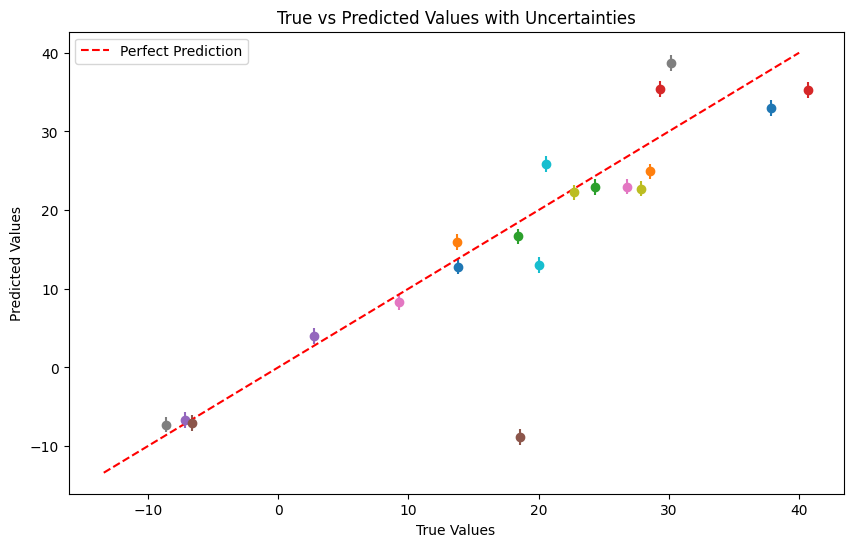

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have already trained and obtained predictions
y_pred = model.predict(Xtest)
num_samples = 1000
predictions = model(Xtest)
pred_dists = tfd.Normal(loc=predictions, scale=1.0)
samples = pred_dists.sample(num_samples)

mean_prediction = np.mean(samples, axis=0)
std_dev_prediction = np.std(samples, axis=0)

# Plotting true vs predicted values with uncertainties
plt.figure(figsize=(10, 6))

# Plotting individual points with error bars (up to 10 points)
for i in range(min(20, len(Ytest))):
    plt.errorbar(Ytest[i], mean_prediction[i], yerr=std_dev_prediction[i], fmt='o')

# Plotting the line y = x for perfect predictions
plt.plot([min(Ytest), 40], [min(Ytest), 40], '--', color='red', label='Perfect Prediction')

plt.title('True vs Predicted Values with Uncertainties')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()


# Conformal prediction

15/15 [==============================] - 0s 2ms/step
0.9019999999999999
6.284189896652216
2/2 [==============================] - 0s 5ms/step


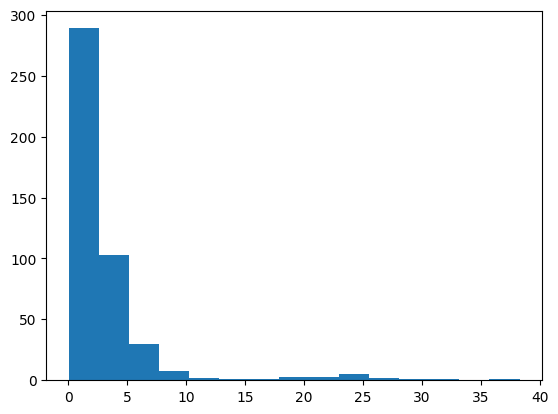

In [ ]:
def s(x,y) :
  return np.abs(x-y)

# train data
X_val , X_test = Xtest[:450], Xtest[450:]
y_val , y_test1 = Ytest[:450], Ytest[450:]

neurone_pred = model.predict(X_val)[:,0]
# Compute S
S = s(neurone_pred,y_val)
plt.hist(S,bins = 15)

# Quantile
alpha = 0.1
n_cal = y_val.shape[0]
alpha_n = (n_cal+1)/n_cal * (1-alpha)
print(alpha_n)
q = np.percentile(S, 100*alpha_n)
print(q)

#Confidence Interval
pred_test = model.predict(X_test)[:,0]
y_confidence_interval_upper = pred_test + q
y_confidence_interval_lower = pred_test - q


Text(0.5, 1.0, '90% confidence intervals produced with naive ICP regression method')

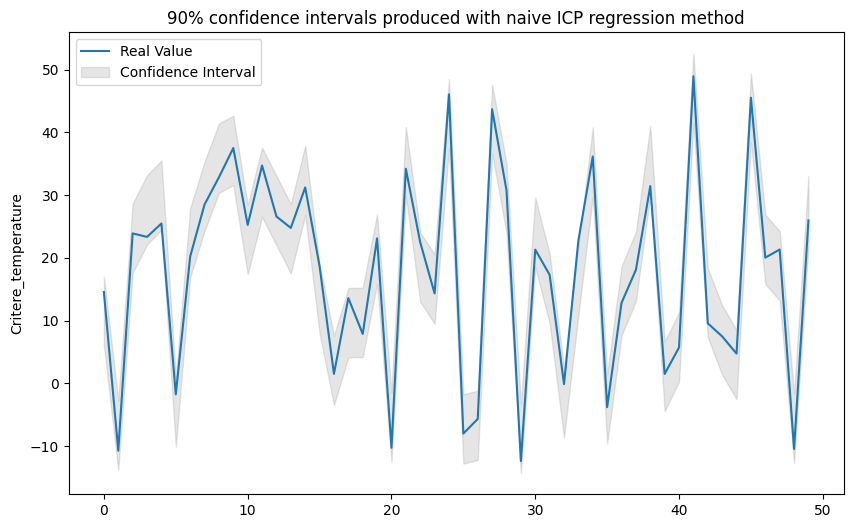

In [ ]:
fig = plt.figure(figsize=(10, 6))

# Plotting the actual values
plt.plot(y_test1, label='Real Value')

# Filling the area between the upper and lower bounds with a color
plt.fill_between(range(len(y_test1)), y_confidence_interval_lower, y_confidence_interval_upper, color='gray', alpha=0.2, label='Confidence Interval')

plt.ylabel('Critere_temperature')
plt.legend()
plt.title('90% confidence intervals produced with naive ICP regression method')